In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

from basicsr.archs.rrdbnet_arch import RRDBNet

from realesrgan import RealESRGANer
from realesrgan.archs.srvgg_arch import SRVGGNetCompact

/home/psdz/miniconda3/envs/SAM/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# params
input_path = "../data/output (3).jpg"
output_path = "results/out.jpg"
model_name = "RealESRGAN_x4plus"
denoise_strength = 0.5
outscale = 4
model_path = "weights/RealESRGAN_x4plus.pth"
suffix = "out"
alpha_upsampler = "realesrgan"
ext = "auto"

In [4]:
model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4)
netscale = 4

In [5]:
upsampler = RealESRGANer(
    scale=netscale,
    model_path=model_path,
    model=model
)

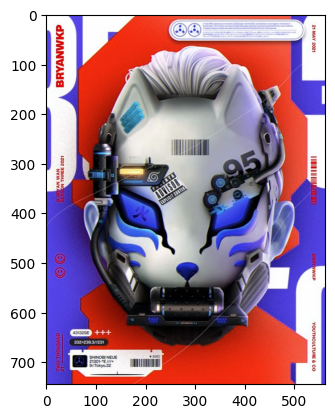

In [6]:
img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
plt.imshow(img)

In [7]:
w, h, c = img.shape
w_block = w // 2
h_block = h // 2
w_pad = w_block // 10
h_pad = h_block // 10

img_block = img[0:w_block+w_pad, 0:h_block+h_pad, :]
# plt.imshow(img_block)
img_block.shape

(409, 309, 3)

In [8]:
output_block, _ = upsampler.enhance(img_block, outscale=outscale)
# plt.imshow(output_block)
output_block.shape

KeyboardInterrupt: 

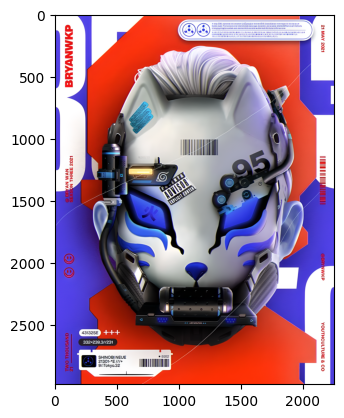

In [ ]:
output, _ = upsampler.enhance(img, outscale=outscale)
plt.imshow(output)

In [ ]:
cv2.imwrite(output_path, output)

True

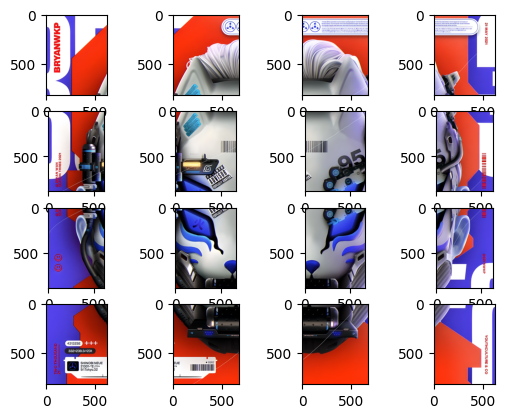

In [7]:
n_blocks = 4
pad_factor = 10

w, h, c = img.shape
w_block = w // n_blocks
h_block = h // n_blocks
w_pad = w_block // pad_factor
h_pad = h_block // pad_factor

plt.figure()

output_full = np.ones((w * outscale, h * outscale, 3))

for i in range(n_blocks):
    for j in range(n_blocks):
        # 切块
        w_is_first = not (w_block * i > 0)
        x1 = w_block * i if w_is_first else w_block * i - w_pad
        w_is_last = not (w_block * (i + 1) < w - 1)
        x2 = w_block * (i + 1) if w_is_last else w_block * (i + 1) + w_pad
        h_is_first = not (h_block * j > 0)
        y1 = h_block * j if h_is_first else h_block * j - h_pad
        h_is_last = not (h_block * (j + 1) < h - 1)
        y2 = h_block * (j + 1) if h_is_last else h_block * (j + 1) + h_pad

        img_block = img[x1: x2, y1: y2, :]

        # sr
        output_block, _ = upsampler.enhance(img_block, outscale=outscale)

        # merge        
        if not w_is_first:
            output_block[:w_pad*outscale, :, :] = \
                output_block[:w_pad*outscale, :, :] * 0.5 + output_full[x1*outscale: x1*outscale+w_pad*outscale, y1*outscale: y2*outscale, :] * 0.5
        if not h_is_first:
            output_block[:, :h_pad*outscale, :] = \
                output_block[:, :h_pad*outscale, :] * 0.5 + output_full[x1*outscale: x2*outscale, y1*outscale: y1*outscale+h_pad*outscale, :] * 0.5

        output_full[x1*outscale: x2*outscale, y1*outscale: y2*outscale, :] = output_block

        plt.subplot(n_blocks, n_blocks, n_blocks*i+j+1)
        plt.imshow(output_block)

In [8]:
cv2.imwrite(output_path, output_full)

True